# DE-test-explorer
1.19.22

Want to explore the Precision-Recall curves generated from this test, specifically the weird elbow that we're seeing for most of the models in the MNAR condition. Is this (the elbow) possibly an artifact of p-value adjustment? How reproducible is the elbowness?

In [1]:
import pandas as pd
import numpy as np
import sys
from scipy import stats
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

# suppressing this CUDA initialization warning I always get
    # this could be dangerous
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# import my modules
sys.path.append('../../../../bin/')
from models.linear import GradNMFImputer
import util_functions
import intermediate_plots

# plotting templates
sns.set(context="talk", style="ticks") 
pal = sns.color_palette()

#### Some configs

In [2]:
# partitioning params
val_frac = 0.3
test_frac = 0.0
# setting this to 0 ensures that no peptides will be filtered out
min_present = 0     # during partitioning
q_anchor=0.35  # these three for MNAR partition 
t_std=0.45
brnl_prob=0.7

# NMF model params
n_factors = 4
tolerance = 0.0001            # 0.0001 is default
max_epochs = 1000             # 1000 is default
learning_rate = 0.01          # 0.01 is default
batch_size = 64               # 64 is default
loss_func = "MSE"

# for determining the ground truth DE peptides
alpha_gt = 0.1
correction = "BH"

# the random number generator
rng = np.random.default_rng(seed=18)

# the random state for the partition
split_rand_state = 18

#### Read in quants matrix, pre-process

In [3]:
# read in 
cond1_df = pd.read_csv(
            "../../2022-10-31_SMTG_data/data/SMTG-ADD-quants.csv")
cond2_df = pd.read_csv(
            "../../2022-10-31_SMTG_data/data/SMTG-HCF-low-quants.csv")

# downsample. Really should do this probabilisticly 
# cond1_df = cond1_df[:10000]
# cond2_df = cond2_df[:10000]

# get the list of peptide IDs, or rather transition group IDs
    # these will be the same for the two datasets
peptide_ids = np.array(cond1_df["pids"])

# now remove the peptide ID columns
to_remove = ["pids"]
cond1_df = cond1_df.drop(to_remove, axis=1)
cond2_df = cond2_df.drop(to_remove, axis=1)

# convert to numpy arrays
cond1_quants = np.array(cond1_df)
cond2_quants = np.array(cond2_df)

print("condition 1 quants: ", cond1_quants.shape)
print("condition 2 quants: ", cond2_quants.shape)

condition 1 quants:  (32614, 9)
condition 2 quants:  (32614, 9)


#### Partition 
MCAR or MNAR. 

In [4]:
# create the combined matrix, to use for imputation 
comb_quants = np.concatenate([cond1_quants, cond2_quants], axis=1)

# this is for eventually separating the reconstructed matrices 
    # into normal and tumor matrices
cols_cutoff = cond1_quants.shape[1]

# MCAR partition 
# train, val, test = util_functions.split(
#                                     comb_quants, 
#                                     val_frac=val_frac,
#                                     test_frac=test_frac, 
#                                     min_present=min_present,
#                                     random_state=split_rand_state,
# )
# MNAR partition 
train, val = util_functions.MNAR_partition_thresholds_matrix(
                                    comb_quants, 
                                    q_anchor=q_anchor, 
                                    t_std=t_std, 
                                    brnl_prob=brnl_prob, 
                                    min_pres=min_present,
                                    rand_state=split_rand_state,
)

#### Get the optimal number of batches for training and eval

In [5]:
# get the optimal number of batches for training
if len(~np.isnan(train)) > 100:
    n_batches = int(np.floor(len(~np.isnan(train)) / batch_size))
    # setting the minimum n_batches to 100
    n_batches = max(n_batches, 100) 
else: 
    n_batches = 1
    
print(n_batches)

509


#### Get the MV fractions from each partition 

In [6]:
# get the missingness fractions
orig_mv_frac = np.count_nonzero(np.isnan(comb_quants)) / comb_quants.size
train_mv_frac = np.count_nonzero(np.isnan(train)) / train.size
val_mv_frac = np.count_nonzero(np.isnan(val)) / val.size

print("original mv frac: ", np.around(orig_mv_frac, decimals=2))
print("training mv frac: ", np.around(train_mv_frac, decimals=2))
print("validation mv frac: ", np.around(val_mv_frac, decimals=2))

original mv frac:  0.0
training mv frac:  0.26
validation mv frac:  0.74


#### Plot the distribution of the partitions

Text(0, 0.5, 'Counts')

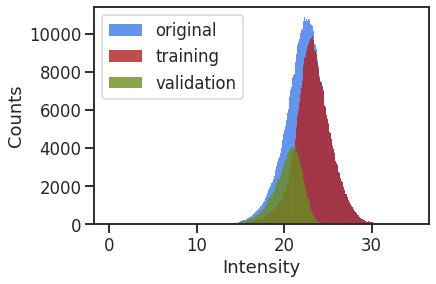

In [7]:
# flatten
quants_rav = comb_quants.ravel()
train_rav = train.ravel()
val_rav = val.ravel()

# get the present values from the original matrix
p_quants_nans = np.isnan(quants_rav)
p_quants_present = quants_rav[~p_quants_nans]

# get present values from the training matrix
train_nans = np.isnan(train_rav)
train_present = train_rav[~train_nans]

# get present values from the validation matrix
val_nans = np.isnan(val_rav)
val_present = val_rav[~val_nans]

quants_max = np.max(p_quants_present)
quants_min = np.min(p_quants_present)

bins_range = np.arange(0, quants_max, 0.1)

plt.figure()
plt.hist(p_quants_present, density=False, bins=bins_range, linewidth=0.01,
         color='cornflowerblue', edgecolor='cornflowerblue', alpha=1.0, label="original")
plt.hist(train_present, density=False, bins=bins_range, linewidth=0.01, 
         color='firebrick', edgecolor='firebrick', alpha=0.8, label="training")
plt.hist(val_present, density=False, bins=bins_range, linewidth=0.01,
        color='olivedrab', edgecolor='olivedrab', alpha=0.8, label="validation")

plt.minorticks_off()

plt.legend()
plt.xlabel("Intensity")
plt.ylabel("Counts")

***

#### NMF impute

In [8]:
# init model 
nmf_model = GradNMFImputer(
                n_rows = train.shape[0], 
                n_cols = train.shape[1], 
                n_factors=n_factors, 
                stopping_tol=tolerance,
                train_batch_size=n_batches, 
                eval_batch_size=n_batches,
                n_epochs=max_epochs, 
                loss_func=loss_func,
                optimizer=torch.optim.Adam,
                optimizer_kwargs={"lr": learning_rate},
                non_negative=True,
                rand_seed=rng.random(),
)
# fit and transform
nmf_recon = nmf_model.fit_transform(train, val)
nmf_full_recon = nmf_model.train_set_transform(train)

  6%|▌         | 57/1000 [01:16<21:08,  1.34s/epoch]

early stopping triggered: standard criteria


#### Get sanity check plots

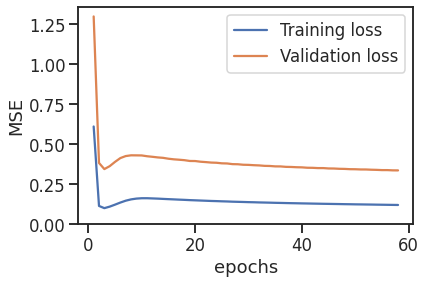

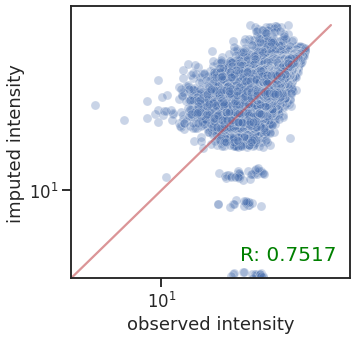

In [ ]:
intermediate_plots.plot_train_loss(
            model=nmf_model, 
            PXD="SMTG", 
            n_row_factors=nmf_model.n_row_factors,
            n_col_factors=nmf_model._n_col_factors, 
            model_type="NMF", 
            eval_loss="MSE",
            tail=None,
)                   
intermediate_plots.real_v_imputed_basic(
            recon_mat=nmf_recon, 
            val_mat=val, 
            PXD="SMTG",
            row_factors=nmf_model.n_row_factors,
            col_factors=nmf_model._n_col_factors,
            model_type="NMF",
            log_transform=False,
            tail="valid",
)
intermediate_plots.real_v_imputed_basic(
            recon_mat=nmf_full_recon,
            val_mat=train,
            PXD="SMTG",
            row_factors=nmf_model.n_row_factors,
            col_factors=nmf_model._n_col_factors,
            model_type="NMF", 
            log_transform=False,
            tail="train",
)

***

#### Get the ground truth p-values (w/o correction)

In [ ]:
pvals_gt = []
for i in range(0, cond1_quants.shape[0]):
    res = stats.ttest_ind(
        cond1_quants[i], cond2_quants[i], nan_policy="omit"
    )
    t_stat = res[0]
    p_val = res[1]
    pvals_gt.append(p_val)
    
reject_null_gt = np.array(pvals_gt) < alpha_gt
DE_peptides_gt = list(peptide_ids[reject_null_gt])

#### Get the ground truth p-values, w/correction

In [ ]:
# # get ground truth DE peptides
# reject_null_gt, pvals_correct_gt = \
#             util_functions.find_DE_peptides(
#                                 cond1_quants, 
#                                 cond2_quants, 
#                                 correction, 
#                                 alpha_gt
#             )
# DE_peptides_gt = list(peptide_ids[reject_null_gt])

#### Split the recon matrix into the two experimental conditions

In [ ]:
cond1_recon_nmf = nmf_recon[:,0:cols_cutoff]
cond2_recon_nmf = nmf_recon[:,cols_cutoff:]

#### Get raw (uncorrected) p-values, for the recon

In [ ]:
pvals_nmf = []
for i in range(0, cond1_recon_nmf.shape[0]):
    res = stats.ttest_ind(
        cond1_recon_nmf[i], cond2_recon_nmf[i], nan_policy="omit"
    )
    t_stat = res[0]
    p_val = res[1]
    pvals_nmf.append(p_val)
    
# the ground truth labels. True means DE peptide, False means not
gt_labels = reject_null_gt.astype(float)

# get the DE probabilities
prob_true_nmf = 1 - np.array(pvals_nmf)

#### Get the corrected p-values for the recon

In [ ]:
# r, cp_vals_nmf = util_functions.find_DE_peptides(
#                     cond1_recon_nmf, cond2_recon_nmf, 
#                     correction, alpha_=alpha_gt)

# # the ground truth labels. True means DE peptide, False means not
# gt_labels = reject_null_gt.astype(float)

# # get the DE probabilities
# prob_true_nmf = 1 - cp_vals_nmf

#### Get the Precision-Recall stats
Including the AUC

In [ ]:
# call the sklearn PR plotting function 
pr_nmf, recall_nmf, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_nmf)

# get the AUCs
nmf_auc = np.around(auc(recall_nmf, pr_nmf), 2)

#### Generate the PR plot

In [ ]:
plt.figure()

plt.plot(
    recall_nmf, pr_nmf, label="NMF (" + str(nmf_auc) + ")")

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("recall")
plt.ylabel("precision")

#### ROC plot instead?

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(gt_labels, prob_true_nmf)

plt.figure()

plt.plot(fpr, tpr, label="NMF")

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

***

## What if we plot the distribution of p-values? 

#### For the ground truth DE test

In [ ]:
# plt.figure()
# plt.hist(pvals_gt, bins=25)

# plt.title("Ground truth", pad=15)
# plt.xlabel("n peptides")
# plt.ylabel("density")

#### For the post-NMF imputation DE test

In [ ]:
# plt.figure()
# plt.hist(pvals_nmf, bins=25)

# plt.title("Post-imputation", pad=15)
# plt.xlabel("n peptides")
# plt.ylabel("density")

#### Plot both on the same axes

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)

# #ax1.hist(pvals_correct_gt, bins=25)
# ax1.hist(pvals_gt, bins=25)
# ax1.set_title("Ground Truth", pad=15)
# ax1.set_xlabel("p-value")
# ax1.set_ylabel("n peptides")

# #ax2.hist(cp_vals_nmf, bins=25)
# ax2.hist(pvals_nmf, bins=25)
# ax2.set_title("Post-imputation", pad=15)
# ax2.sharey(ax1)
# ax2.set_xlabel("p-value")

# fig.tight_layout()